In [2]:
import numpy as np
from scipy.optimize import root
from scipy.optimize import root
import matplotlib.pyplot as plt
from typing import List
import pandas as pd
from scipy.optimize import minimize

In [3]:
# res = []
# def calc_J(J):

#      guess = [604.576,605.048,603.034,603.379,604.657,603.612]
#      for wgp, rgipg, rpr in zip(zip(*WGP), zip(*RGIPG), zip(*RPR)):
#           def func(p_i):
#                return [
#                     press/rpr[i-1] - (1 - (wgp[i] + sum([J[i][j] * (press**2 - p_i[j]**2) for j in range(n)]))/rgipg[i-1])
#                for i, press in enumerate((p_i)[0:])]
#           sol = root(x0=guess, fun=func)
#           guess = sol.x
#           assert all(map(lambda x: abs(x) < .0001, sol.fun)), f'{sol.fun}'
#           res.append(sol.x)



class Material_Balance:    
    c00 = [ 1.58136372e-08, -2.11511088e-05,  8.41243666e-03,  3.44397433e-03, 9.78500838e+01]
    f_pz = np.poly1d(c00)
    @staticmethod
    def z_value(p_mpa:float, t_kelv:float=None,t_krit:float=190, p_krit:float=4.6)->float:
        """Формула Мандрыгина для Z

        Args:
            p_mpa (float): Давление, МПА
            t_kelv (float, optional): Температура, К. Defaults to None.
            t_krit (float, optional): Критич. Температура, К. Defaults to 190.
            p_krit (float, optional):  Критич. Давление, МПа. Defaults to 4.6.

        Returns:
            float: Значение сверхсжимаемости Z
        """
        return 5.64E-06 * p_mpa**2 -0.002039437*p_mpa +  1.0062
        t = 300 if t_kelv is None else t_kelv
        return 1-0.427*p_mpa/p_krit*(t/t_krit)**(-3.688)
    @staticmethod 
    def p_z(press): return Material_Balance.f_pz(press)
    @staticmethod
    def eq_press_one_date(
            p:np.ndarray,
            p0:np.ndarray,
            wgp:np.ndarray,
            J:np.ndarray,
            G_0:np.ndarray,)->np.ndarray:    
            flow_sum = Material_Balance.get_flows(p,J)
            f = p - p0*(1 - (wgp  + flow_sum)/G_0)           
            return f
    @staticmethod
    def get_flows(press:np.ndarray, J:np.ndarray):
            return (J * (press**2 - press.reshape(-1,1)**2)).sum(0)
    @staticmethod
    def get_press_all_dates(
        p_initial:np.ndarray,
        wgp_by_dates:np.ndarray,
        J_ij:np.ndarray,
        rgip_initial:np.ndarray,
        method)->List[np.ndarray]:
            res = []
            guess = p_initial
            p_prev = p_initial
            for wgpt_curr, wgp_curr in list(zip(wgp_by_dates.cumsum(0), wgp_by_dates))[::]:    
                sol = root(
                    fun=Material_Balance.eq_press_one_date, 
                    x0=guess,
                    args =  (
                        p_prev,
                        wgp_curr,
                        J_ij,
                        rgip_initial-wgpt_curr+wgp_curr,
                    ),
                        method=method
                    )
                # assert all(map(lambda x: abs(x) < 1, sol.fun)), f'{sol.fun}'
                res.append(sol)
                p_prev = sol.x
                guess = sol.x
            return res
    def __init__(self, wgp:np.ndarray, g_0:np.ndarray, p_initial:np.ndarray) -> None:
          self.wgp = wgp
          self.g_0 = g_0
          self.p_initial = self.p_z(p_initial)

    def calc(self, J_ij:np.ndarray, method="hybr"):
        res = self.get_press_all_dates(
            p_initial=self.p_initial,
            wgp_by_dates=self.wgp,
            J_ij=J_ij,
            rgip_initial=self.g_0,
            method=method
        )
        return res        
    


(array([[609.20154632, 609.20154632, 609.20154632, 609.20154632],
        [487.27147583, 601.6164474 , 601.6164474 , 601.6164474 ],
        [366.9894791 , 468.06728564, 582.12573069, 582.12573069],
        [232.07715978, 335.22442601, 437.70579832, 550.10698256],
        [ 62.48802679, 192.60068301, 297.65863459, 400.15975388],
        [ 72.8653032 ,  40.05123645, 162.89746869, 266.1249493 ],
        [ 73.84595984,  41.77828155,  29.74664692, 143.03367551],
        [ 72.03305811,  41.90008119,  30.03646266,  25.17123014],
        [ 70.37259874,  42.00286804,  30.31327604,  25.45773659],
        [ 68.84547322,  42.0887766 ,  30.57811867,  25.73569474],
        [ 67.43573896,  42.15966843,  30.83188647,  26.00575094]]),
 <Axes: >)

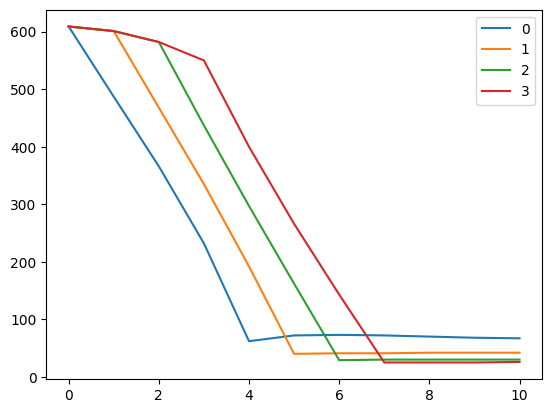

In [4]:
wgp_all = np.array(
      [[   0,    0,   0,   0,],
       [ 250,    0,   0,   0,],
       [ 250,  250,   0,   0,],
       [ 250,  250, 250,   0,],
       [ 250,  250, 250, 250,],
       [   0,  250, 250, 250,],
       [   0,    0, 250, 250,],
       [   0,    0,   0, 250,],
       [   0,    0,   0,   0,],
       [   0,    0,   0,   0,],
       [   0,    0,   0,   0,]])

J_ij = np.ones((4,4))*.0001
p_initial = np.ones((4,))*600
rgip0  = np.ones((4,))*wgp_all.sum()/4

calc = Material_Balance(wgp_all*.95, rgip0,p_initial)
res_calc = calc.calc(J_ij)
(
    np.array([r.x for r in res_calc]),
    pd.DataFrame(np.array([r.x for r in res_calc]).astype(int)).plot()
)

In [5]:
list_methods = ['hybr',
'lm',
'broyden1',
'broyden2',
'anderson',
'linearmixing',
'diagbroyden',
'excitingmixing',
'krylov',
'df-sane']


<Axes: >

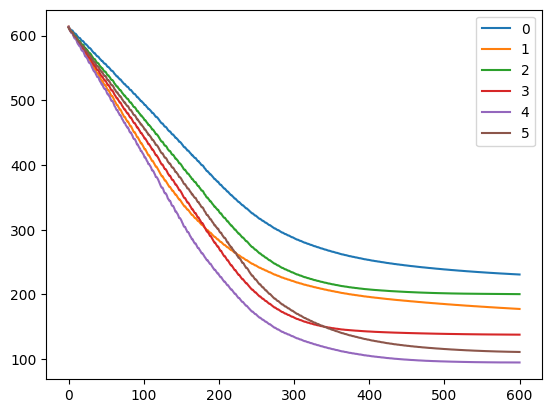

In [6]:
df = pd.read_excel("data_6wells.xlsx")
WGP2 = df.pivot_table('WGP',index='dates',columns='well_name').to_numpy()
RGIPG2 = df.pivot_table('RGIPG',index='dates',columns='well_name').to_numpy()
RPR2 = df.pivot_table('RPR',index='dates',columns='well_name').to_numpy()
deposts = RGIPG2[0]
mat_bal2 = Material_Balance(WGP2,deposts,RPR2[0])
res_calc = mat_bal2.calc(np.ones((6,6)))

pd.DataFrame(np.array([r.x for r in res_calc])).plot()



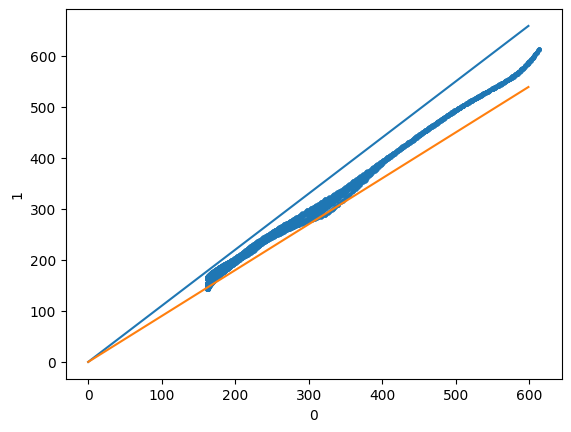

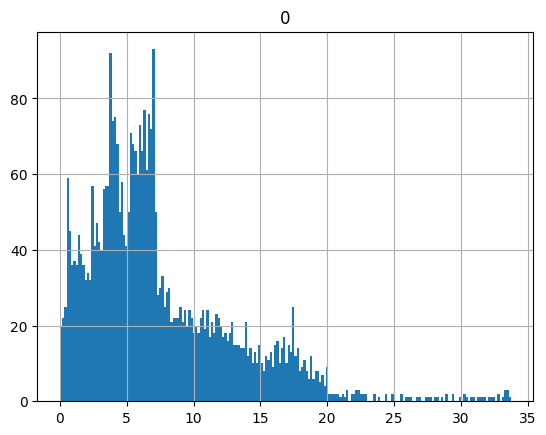

In [7]:
class Solver_matbal:
    def __init__(self, mat_bal:Material_Balance, rpr:np.ndarray):
        self.matbal = mat_bal
        self.rpr = mat_bal.p_z(rpr)
    def get_j2d(self, j_1d:np.ndarray):
        indecies = np.triu_indices_from(np.ones((6,6)),1)
        b = np.zeros((6,6))
        b[indecies] = j_1d
        return b + b.T
    def get_press(self, j_1d:np.ndarray):
        indecies = np.triu_indices_from(np.ones((6,6)),1)
        b = np.zeros((6,6))
        b[indecies] = j_1d
        J_2d = self.get_j2d(j_1d)
        res_calc = self.matbal.calc(J_2d)
        press = np.array([r.x for r in res_calc])
        return press

    def get_diff(self, j_1d:np.ndarray):
        press_calc = self.get_press(j_1d)    
        fact_model = np.array([press_calc.reshape(-1), self.rpr.reshape(-1)]).T
        diff = (np.diff(fact_model, axis=1))**2
        return diff
    def opt_(self):
        x0 = np.random.rand(15)
        bnds = [(0,100) for _ in x0]
        upper = 999999
        lower =  0
        bnds = [
            (lower,upper), #[0, 1]  0
            (lower,upper), #[0, 2]  1
            (lower,upper), #[0, 3]  2
            (lower,upper), #[0, 4]  3
            (lower,upper), #[0, 5]  4
            (0,0),         #[1, 2]  5
            (lower,upper), #[1, 3]  6
            (0,0),         #[1, 4]  7
            (0,0),         #[1, 5]  8
            (lower,upper), #[2, 3]  9
            (0,0),         #[2, 4]  10
            (lower,upper), #[2, 5]  11
            (0,0),         #[3, 4]  12
            (0,0),         #[3, 5]  13
            (lower,upper), #[4, 5]] 14
        ]
        # power_func = np.vectorize(lambda x: x**2 if 150 < x <= 300 else x)
        power_func = np.vectorize(lambda x:x)
        sol = minimize(fun=lambda x: power_func(self.get_diff(x)).sum(),
            x0=x0,
            # method='powell',
            # tol= 1e-3,
            # options={'maxiter': 1e+8, 'disp': True},
            bounds=bnds)
        return sol    
    def get_plots(self, res_opt):
        j_2d = self.get_j2d(res_opt.x)
        res = self.matbal.calc(j_2d)
        press_calc = np.array([r.x for r in res])
        fact_model = np.array([press_calc.reshape(-1), self.rpr.reshape(-1)]).T
        diff = abs(np.diff(fact_model, axis=1))
        ax = pd.DataFrame(fact_model).plot.scatter(x=0,y=1,marker='.')
        ax.plot(np.arange(600),np.arange(600)*1.1)
        ax.plot(np.arange(600),np.arange(600)*.9)
        pd.DataFrame(diff).hist(bins=200)




solver = Solver_matbal(mat_bal2, RPR2)
res_opt = solver.opt_()
solver.get_plots(res_opt)











array([[<Axes: title={'center': '0'}>]], dtype=object)

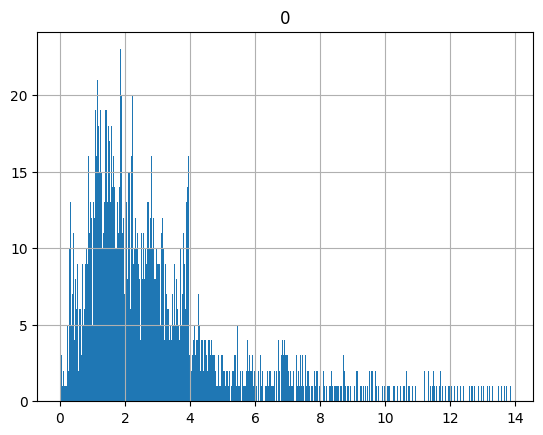

In [17]:
j_2d = solver.get_j2d(res_opt.x)
res =  solver.matbal.calc(j_2d)
press_calc = np.array([r.x for r in res])
fact_model = np.array([press_calc.reshape(-1), solver.rpr.reshape(-1)]).T
diff = abs(np.diff(fact_model, axis=1))
# ax = pd.DataFrame(fact_model).plot.scatter(x=0,y=1,marker='.')
# ax.plot(np.arange(600),np.arange(600)*1.05)
# ax.plot(np.arange(600),np.arange(600)*.95)
# ax.set_xlim(300,400)
# ax.set_ylim(300,400)
# ax.plot()
p_model = solver.rpr.reshape(-1,1)
pd.DataFrame(diff /p_model*100 ).hist(bins=1000)